# Module 3: Infer Language Models TEST

* DS 6001
* Raf Alvarado

We now create a series of langage models and evaluate them.

# Set Up

## Configure

In [1]:
text_file1 = '../MOD02--TextModels/austen-persuasion.csv'
text_file2 = '../MOD02--TextModels/austen-sense.csv'

In [2]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

## Import libraries

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline

# Import and combine texts

In [4]:
text1 = pd.read_csv(text_file1)
text2 = pd.read_csv(text_file2)

In [5]:
text1.head()

,chap_num,para_num,sent_num,token_num,token_str
0,1,1,0,0,Sir
1,1,1,0,1,Walter
2,1,1,0,2,Elliot
3,1,1,0,3,of
4,1,1,0,4,Kellynch


In [6]:
text1['book_id'] = 1
text2['book_id'] = 2

In [7]:
text1.head()

,chap_num,para_num,sent_num,token_num,token_str,book_id
0,1,1,0,0,Sir,1
1,1,1,0,1,Walter,1
2,1,1,0,2,Elliot,1
3,1,1,0,3,of,1
4,1,1,0,4,Kellynch,1


In [8]:
tokens = pd.concat([text1, text2]).dropna()

In [9]:
tokens = tokens.set_index(OHCO)

# Create a vocabulary

In [91]:
tokens['term_str'] = tokens['token_str'].str.lower().str.replace(r'[\W_]', '')
tokens = tokens[~tokens.term_str.str.match('^\s*$')] # Remove blank produced by previous line

In [92]:
vocab = tokens['term_str'].value_counts()\
    .to_frame()\
    .reset_index()\
    .rename(columns={'term_str':'n', 'index':'term_str'})\
    .sort_values('term_str')
vocab.index.name = 'term_id'

In [93]:
vocab.head()

,term_str,n
term_id,,
3410,1,3
7294,15,1
8105,16,1
5653,1760,1
6283,1784,1


In [94]:
vocab.sample(5)

,term_str,n
term_id,,
1423,order,13
4103,compunction,2
1577,baronet,11
4771,jump,2
362,coming,70


# Create Unigram Model

In [95]:
n_tokens = vocab.n.sum()
vocab['p'] = vocab['n'] / n_tokens
vocab['log_p'] = np.log2(vocab['p'])

In [96]:
n_tokens

204804

In [97]:
vocab.sort_values('p', ascending=False).head(10)

,term_str,n,p,log_p
term_id,,,,
0,the,7436,0.036308,-4.783573
1,to,6924,0.033808,-4.886494
2,and,6290,0.030712,-5.025040
3,of,6145,0.030004,-5.058687
4,her,3747,0.018296,-5.772364
5,a,3687,0.018003,-5.795653
6,in,3368,0.016445,-5.926208
7,was,3198,0.015615,-6.000930
8,i,3128,0.015273,-6.032860


In [98]:
smooth = vocab['p'].min()
def predict_sentence(sent_str):
    
    tokens = pd.DataFrame(sent_str.lower().split(), columns=['term_str'])
    tokens = tokens.merge(vocab, on='term_str', how='left')
    tokens.loc[tokens['p'].isna(), ['p', 'log_p']] = [smooth, np.log2(smooth)]
    p = tokens['p'].product()
    log_p = tokens['log_p'].sum()
    
    print('-' * 80)
    print("p('{}') = {}; log2: {}".format(sent_str, p, log_p))
    print('-' * 80)
    print(tokens)
    print('-' * 80)

In [99]:
predict_sentence('I love you')
predict_sentence('I love cars')
predict_sentence("I want to")
predict_sentence("anne said to")
predict_sentence("said to her")
predict_sentence('she said')

--------------------------------------------------------------------------------
p('I love you') = 7.881903279421726e-08; log2: -23.59688071314444
--------------------------------------------------------------------------------
  term_str     n         p      log_p
0        i  3128  0.015273  -6.032860
1     love   119  0.000581 -10.749067
2      you  1819  0.008882  -6.814955
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
p('I love cars') = 4.3330969100724165e-11; log2: -34.42581054079592
--------------------------------------------------------------------------------
  term_str       n         p      log_p
0        i  3128.0  0.015273  -6.032860
1     love   119.0  0.000581 -10.749067
2     cars     NaN  0.000005 -17.643884
--------------------------------------------------------------------------------
--------------------------------------------------------------------

# Buld N-Gram models

This function generates models up to the length specified. Generates ngrams by binding columns of token strings where their sequence numbers are offset by one for each n.

In [101]:
def get_ngrams(tokens, n=2):
    
    # Create list to store copies of tokens table
    X = []
    
    # We convert the index to cols in order to change the value of token_num
    X.append(tokens['term_str'].reset_index())
        
    # Create copies of token table for each level of ngram, offset by 1, and 
    # merge with previous 
    for i in range(1, n):
        X.append(X[0].copy())
        X[i]['token_num'] = X[i]['token_num'] + i
        X[i] = X[i].merge(X[i-1], on=OHCO, how='outer', sort=True).fillna('<s>')
        
    # Compress tables to unique ngrams with counts
    for i in range(0, n):
        X[i] = X[i].drop(OHCO, 1)
        cols = X[i].columns.tolist()
        X[i]['n'] = 0
        X[i] = X[i].groupby(cols).n.apply(lambda x: x.count()).to_frame()
        X[i].index.names = ['w{}'.format(j) for j in range(i+1)]
            
    # Return just the ngram tables
    return X

## Generate three models

Unigram, bigram, and trigram

In [117]:
m1, m2, m3 = get_ngrams(tokens, n=3)

## Compute joint probabilities

In [118]:
m1['p'] = m1['n'] / m1['n'].sum()
m2['p'] = m2['n'] / m2['n'].sum()
m3['p'] = m3['n'] / m3['n'].sum()

In [119]:
m1.sort_values('p', ascending=False).head()

,n,p
w0,,
the,7436,0.036308
to,6924,0.033808
and,6290,0.030712
of,6145,0.030004
her,3747,0.018296


In [120]:
m2.sort_values('p', ascending=False).head()

n         p
w0  w1                 
<s> and  1450  0.006626
    i    1072  0.004898
    but   948  0.004332
of  the   857  0.003916
to  be    814  0.003720

In [121]:
m3.sort_values('p', ascending=False).head(15)

n         p
w0  w1  w2                      
<s> <s> and       1449  0.006222
        i         1071  0.004599
        but        948  0.004071
        she        706  0.003032
        he         587  0.002521
mrs <s> <s>        530  0.002276
<s> <s> the        512  0.002199
        it         445  0.001911
it  <s> <s>        369  0.001585
<s> <s> said       353  0.001516
        you        262  0.001125
her <s> <s>        244  0.001048
<s> <s> they       241  0.001035
        jennings   235  0.001009
him <s> <s>        227  0.000975

## Compute conditional probabilities

$p(w_1|w_0) = p(w_0, w_1) / p(w_0)$

$p(w_2|w_0,w_1) = p(w_0, w_1, w_2) / p(w_0, w_1)$

In [122]:
m2m = m2.n.unstack().fillna(0).apply(lambda x: x / x.sum(), 1)

In [30]:
m3m = m3.n.unstack().fillna(0).apply(lambda x: x / x.sum(), 1)

In [135]:
m2m.head()

w1,1,15,16,1760,1784,1785,1787,1789,1791,1800,...,your,yours,yourself,yourselves,youth,youthful,z,zeal,zealous,zealously
w0,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.333333,0.0,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1760,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1784,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
m3m.head()

w2                      1   15   16  1760  1784  1785  1787  1789  1791  \
w0 w1                                                                     
   <s>           0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
   accidentally  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
   always        0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
   and           0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
   at            0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   

w2                 ...      your  yours  yourself  yourselves  youth  \
w0 w1              ...                                                 
   <s>             ...       0.0    0.0       0.0         0.0    0.0   
   accidentally    ...       0.0    0.0       0.0         0.0    0.0   
   always          ...       0.0    0.0       0.0         0.0    0.0   
   and             ...       0.0    0.0       0.0         0.0    0.0   
   at              ...       0.0    0.0       0.0         0.0    0.0   

w2               youthful    z  zeal  zealous  zealously  
w0 w1                                                     
   <s>                0.0  0.0   0.0      0.0        0.0  
   accidentally       0.0  0.0   0.0      0.0        0.0  
   always             0.0  0.0   0.0      0.0        0.0  
   and                0.0  0.0   0.0      0.0        0.0  
   at                 0.0  0.0   0.0      0.0        0.0  

[5 rows x 8070 columns]

# Explore

In [181]:
m2m.loc[['he','she','it','anne','wentworth'], ['is','had','was','felt','thought','looked','said','saw']].style.background_gradient(cmap='Greens')

w1,is,had,was,felt,thought,looked,said,saw
w0,,,,,,,,
he,0.0578035,0.14499,0.120906,0.00529865,0.00481696,0.00867052,0.0163776,0.00529865
she,0.0242842,0.148967,0.135194,0.0181225,0.00978615,0.0050743,0.0105111,0.0159478
it,0.0969589,0.0225403,0.178175,0.000357782,0.000357782,0.000357782,0.000357782,0
anne,0.00397614,0.0755467,0.0894632,0.0178926,0.00397614,0.00198807,0.00198807,0.00596421
wentworth,0.0137615,0.0366972,0.0825688,0,0,0.00458716,0.00917431,0.00458716


In [180]:
m2m.loc[['he','she'],['felt','said']].style.background_gradient(cmap='Greens')

w1,felt,said
w0,,
he,0.00529865,0.0163776
she,0.0181225,0.0105111


# Generate Text

We use "stupid back-off" to account for missing ngrams.

In [208]:
def generate_text(start_word='she', n=250):
    words = [start_word]
    for i in range(n):
        if len(words) == 1:
            w = m2m.loc[start_word]
            next_word = m2m.loc[start_word].sample(weights=w).index.values[0]
        elif len(words) > 1:
            bg = tuple(words[-2:])
            try:
                w = m3m.loc[bg]
                next_word = m3m.loc[bg].sample(weights=w).index.values[0]
            except KeyError:
                ug = bg[1]
                if ug == '<s>':
                    next_word = m1.sample(weights=m1.p).index[0]
                else:
                    w = m2m.loc[ug]
                    next_word = m2m.loc[ug].sample(weights=w).index.values[0]
        words.append(next_word)
    text = ' '.join(words)
    text = text.replace(' <s> <s>', '.\n') + '.'
    text = text.upper() # To give that telegraph message look :-)
    print(text)

In [209]:
generate_text('the')

THE WORSE I CAN EASILY BELIEVE THAT IT WAS TO TELL.
 MY ACCOUNT.
 ALL EVENTS TO KNOW SOMETHING OR A SCRUPLE WAS THERE HOPING FOR SOME TIME AFTER ALL HER WATCHFULNESS TO ASCERTAIN THAT NO TENANT HAS MORE THAN FORTY YEARS HAD CHANGED HER SEAT ON PURPOSE THAT FREEDOM WOULD BE HIGHLY EXPEDIENT FOR WILLOUGHBY S OPINION EITHER ITS CONSTANCY OR ITS ENVIRONS FOR YOUNG PEOPLE OF RANK PEOPLE OF BETTER INCOME THAN MYSELF.
 A LITTLE PLEASURE BECAUSE MISS DASHWOOD.
 SUCH WORKS OF OUR PARTING THOUGH EARNESTLY DID SHE THINK IT MUST BE AN EXCESSIVELY PRETTY AND SHE MUST BE NATURE MAN S SAKE THESE LAST FOUR AND TWENTY MUST HAVE THOUGHT ABOUT ME AND BE EXCEEDINGLY WELCOME TO BED.
 BY MANY HOURS SOONER STILL.
 HARP FLOWER STANDS AND LITTLE TABLES PLACED IN A COUNTY SO FAR IT WAS RATHER ILL JUDGED ILL FATED WALK TO THE HOUSE YOU MAY SEE HER.
 THE VISIT TO LADY RUSSELL TO SEE YOU BUT THEY WAS IN EVERY HOUSE TO WHICH COLONEL BRANDON APPEARED TO HER.
 OBJECTS THROUGH THE MISTY GLASSES THE LAST EVENING OF THE

In [203]:
generate_text('she')

SHE WAS IN THE SUPPOSITION OF HIS JUSTIFYING THE HOPES WHICH SUNK THE HEART OF MARIANNE WITH ENERGY.
 TO ALL THE PRECIOUS CARD.
 FAIL.
 WAS CALLED TOWARDS THE EVENING BY THEMSELVES TO LADY MIDDLETON.
 TO SEE BUT ONE MUST NOT SAY A VERY GOOD HUMOURED FELLOW AND HAS GOT A LOCK OF HER SISTERS TO SEE THE MISS DASHWOODS ENTERED THE ROOM SOON AFTERWARDS RISING AND PACING THE ROOM WAS OVER HUSHED INTO COLD COMPOSURE DETERMINED SILENCE OR INSIPID TALK TO HER AND LISTENED KINDLY WHILE MRS.
 FROM ONE IMAGE OF MR ELLIOT.
 SLOW WAS THE EVENING WAS OVER ANNE COULD LISTEN NO LONGER AN EVIL EYE ON ANYONE INTENDING TO INHABIT OVERCAME THEIR DEJECTION AND A WAITER RATHER MORE THAN EXCUSABLE IN THE PITYING EYE WITH WHICH CHARLES WAS LISTENED TO HENRIETTA HAD AT FIRST BEEN CALLED FORTH IN HERSELF THE COMFORT OF THE EVENT WHICH THEY ALL LOOKED THEIR ASSENT.
 HAD BEEN BY YOUR MARRYING HIM AS A DUTY.
 ZEAL OF THE HOUSE DREW HER EYES BRIGHTENED AT THE SAME TIME.
 UP THE ENGAGEMENT FOR SHE HAD SUFFERED FROM T

# Predict Sentences

In [388]:
def predict_sentence2(sent_str):
    
    sent_str = sent_str.lower()
    
    bigrams = []
    trigrams = []
    unigrams = [token for token in sent_str.split()]
    
    for i in range(len(unigrams)):
        bigrams.append(tuple(unigrams[i:i+2]))
        trigrams.append(tuple(unigrams[i:i+3]))
    
    bigrams = bigrams[:-1]
    trigrams = trigrams[:-2]
        
    alpha = 0.00000000001
    
    # Get unigram prob
    try:
        p1 = np.log(m1.loc[unigrams].p.fillna(alpha)).sum()
    except KeyError as e:
        print('\t', e)
        p1 = np.log(alpha) * len(unigrams)
    print(unigrams, p1)

    # Get bigram prob
    try:
        p2 = np.log(m2.loc[bigrams].p.fillna(alpha)).sum()
    except KeyError as e:
        print('\t', e)
        p2 = np.log(alpha) * len(bigrams)
    print(bigrams, p2)

    # Get trigram prob
    try:
        p3 = np.log(m3.loc[trigrams].p.fillna(alpha)).sum()
    except KeyError as e:
        print('\t', e)
        p3 = np.log(alpha) * len(trigrams)
    print(trigrams, p3)
    
    return p1, p2, p3


In [448]:
sentences = """
i am here now
here I am now
she said to him
she said to her
he said to him
he said to her
star trek really rocks 
she really wanted wentworth
amazon stock fell far
she told her that
how do you do
""".split('\n')[1:-1]

In [449]:
probs = []
for sentence in sentences:
    probs.append(predict_sentence2(sentence))

['i', 'am', 'here', 'now'] -24.053232774603956
[('i', 'am'), ('am', 'here'), ('here', 'now')] -44.07134009539731
[('i', 'am', 'here'), ('am', 'here', 'now')] -37.68668454250307
['here', 'i', 'am', 'now'] -24.053232774603956
[('here', 'i'), ('i', 'am'), ('am', 'now')] -28.554111848879636
[('here', 'i', 'am'), ('i', 'am', 'now')] -22.637055497457297
['she', 'said', 'to', 'him'] -18.79701197413468
[('she', 'said'), ('said', 'to'), ('to', 'him')] -26.02439501045974
[('she', 'said', 'to'), ('said', 'to', 'him')] -22.924737569909077
['she', 'said', 'to', 'her'] -17.579515162691358
[('she', 'said'), ('said', 'to'), ('to', 'her')] -24.90709058877948
[('she', 'said', 'to'), ('said', 'to', 'her')] -23.617884750469024
['he', 'said', 'to', 'him'] -19.08143730406619
[('he', 'said'), ('said', 'to'), ('to', 'him')] -25.865330315830057
[('he', 'said', 'to'), ('said', 'to', 'him')] -22.924737569909077
['he', 'said', 'to', 'her'] -17.863940492622866
[('he', 'said'), ('said', 'to'), ('to', 'her')] -24.74

/Users/rca2t/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/rca2t/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/rca2t/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.h

In [450]:
predictions = pd.DataFrame(np.array(probs), columns=['uni','bi', 'tri'], index=sentences)

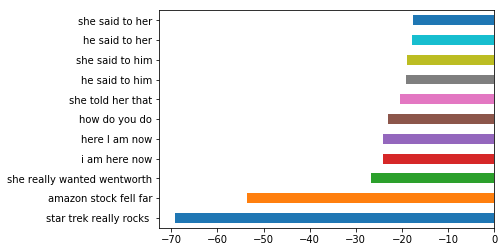

In [452]:
predictions.uni.sort_values().plot.barh()

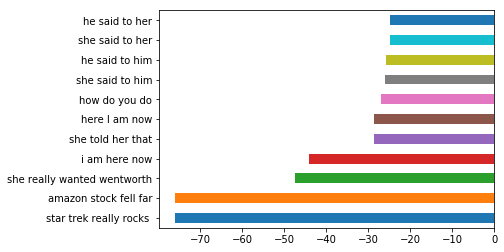

In [453]:
predictions.bi.sort_values().plot.barh()

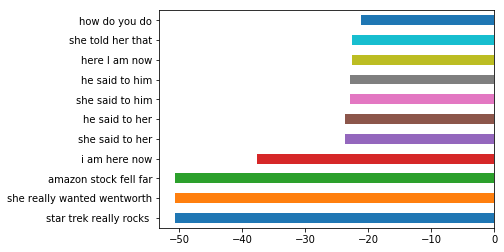

In [454]:
predictions.tri.sort_values().plot.barh()